# Assignment 2 - Expected SARSA (Group 13)
| Name | Student ID |
| --- | --- |
| Dhanush Kovi | CB.EN.U4AIE21025 |
| Aakash Jammula | CB.EN.U4AIE21019 |
| Harshanth CS | CB.EN.U4AIE21016 |
| Govind R Nair | CB.EN.U4AIE21013 |

This notebook contains a Python implementation for the Expected SARSA algorithm for maze environment.

**Reference: (given in question)**

[https://github.com/DavidMouse1118/Reinforcement-Learning-Maze-World/blob/master/RL_brain_expected_sarsa.py](https://github.com/DavidMouse1118/Reinforcement-Learning-Maze-World/blob/master/RL_brain_expected_sarsa.py)

**Modifications:**
Added energy constraint to the maze environment.
1. The agent has a limited amount of energy. The agent can move in the maze until the energy is exhausted. The agent will be reset to the start position if the energy is exhausted.
2. If the agent has reached the goal state and the energy is not exhausted, then the reward is increased by remaining energy.
3. The goal is to reach the goal state with maximum energy remaining.

**GitHub Repository:** [https://github.com/dkvc/SpringSem_RLAssg2](https://github.com/dkvc/SpringSem_RLAssg2)

## Packages

In [2]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tkinter as tk

## Parameters

In [3]:
# Debug flag
DEBUG = 1

# Maze parameters
MAZE_H = 10
MAZE_W = 10
UNIT = 40

# Simulation parameters
sim_speed = 0.05
showRender = False
episodes = 10000
renderEveryNth = 10000
printEveryNth = 100
do_plot_rewards = True

In [4]:
# Agent & Environment parameters
agentXY = [0, 0]
goalXY = [4, 4]

wall_shape=np.array([[7,4],[7,3],[6,3],[6,2],[5,2],[4,2],[3,2],[3,3],[3,4],[3,5],[3,6],[4,6],[5,6]])
pits=np.array([[1,3],[0,5], [7,7]])

## Expected SARSA Algorithm
The implementation of Expected SARSA algorithm is same as given in the reference.

![Expected Sarsa Pseudocode](./images/pseudocode.png)

In [5]:
class rlalgorithm:

    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.1):
        self.actions = actions  
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.display_name="Expected Sarsa"
        print(f"Using {self.display_name} ...")

    '''Choose the next action to take given the observed state using an epsilon greedy policy'''
    def choose_action(self, observation):
        # Add non-existing state to our q_table
        self.check_state_exist(observation)
 
        # Select next action
        if np.random.uniform() >= self.epsilon:
            # Choose argmax action
            state_action_values = self.q_table.loc[observation, :]
            action = np.random.choice(state_action_values[state_action_values == np.max(state_action_values)].index) # handle multiple argmax with random
        else:
            # Choose random action
            action = np.random.choice(self.actions)

        return action


    '''Update the Q(S,A) state-action value table using the latest experience
       This is a not a very good learning update 
    '''
    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_current = self.q_table.loc[s, a]

        if s_ != 'terminal':
            # calculate expected value according to epsilon greedy policy
            state_action_values = self.q_table.loc[s_,:]
            value_sum = np.sum(state_action_values)
            max_value = np.max(state_action_values)
            max_count = len(state_action_values[state_action_values == max_value])
            k = len(self.actions) # total number of actions

            expected_value_for_max = max_value * ((1 - self.epsilon) / max_count + self.epsilon / k) * max_count
            expected_value_for_non_max = (value_sum - max_value * max_count) * (self.epsilon / k)

            expected_value = expected_value_for_max + expected_value_for_non_max

            q_target = r + self.gamma * expected_value # max state-action value
        else:
            q_target = r  # next state is terminal

        self.q_table.loc[s, a] += self.lr * (q_target - q_current)  # update current state-action value

        return s_, self.choose_action(str(s_))


    '''States are dynamically added to the Q(S,A) table as they are encountered'''
    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = pd.concat([self.q_table, pd.DataFrame([[0]*len(self.actions)], columns=self.q_table.columns, index=[state])])

    def save(self, filename):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'wb') as file:
            pickle.dump(self.q_table, file)

    def load(self, filename):
        with open(filename, 'rb') as file:
            self.q_table = pickle.load(file)

## Building Maze Environment

![Maze](./images/env_maze.png)

The maze environment consists of `MAZE_H` x `MAZE_W` grid. The agent can move in four directions: up, down, left, and right. 
1. The agent receives a reward of -0.1 for each step taken in the maze. 
2. The agent receives a reward of 1 if it reaches the goal state. 
3. The agent receives a reward of -0.3 if it reaches the wall. 
4. The agent receives a reward of -10 if it falls into pit.
4. The agent receives a reward of -20 if energy is exhausted.

In [6]:
origin = np.array([UNIT/2, UNIT/2])

class Maze(tk.Tk, object):
    def __init__(self, agentXY, goalXY, walls=[],pits=[], energy_capacity=50, energy_factor=0.01):
        super(Maze, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.wallblocks = []
        self.pitblocks=[]
        self.UNIT = UNIT  
        self.MAZE_H = MAZE_H
        self.MAZE_W = MAZE_W
        self.energy_capacity = energy_capacity
        self.energy_factor = energy_factor
        self.energy = energy_capacity
        self.max_energy = 0
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_H * UNIT, MAZE_W * UNIT))
        self.build_shape_maze(agentXY, goalXY, walls, pits)
        #self.build_maze()

    def build_shape_maze(self,agentXY,goalXY, walls,pits):
        self.canvas = tk.Canvas(self, bg='white',
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)


        for x,y in walls:
            self.add_wall(x,y)
        for x,y in pits:
            self.add_pit(x,y)
        self.add_goal(goalXY[0],goalXY[1])
        self.add_agent(agentXY[0],agentXY[1])
        self.canvas.pack()

    '''Add a solid wall block at coordinate for centre of bloc'''
    def add_wall(self, x, y):
        wall_center = origin + np.array([UNIT * x, UNIT*y])
        self.wallblocks.append(self.canvas.create_rectangle(
            wall_center[0] - 15, wall_center[1] - 15,
            wall_center[0] + 15, wall_center[1] + 15,
            fill='black'))

    '''Add a solid pit block at coordinate for centre of bloc'''
    def add_pit(self, x, y):
        pit_center = origin + np.array([UNIT * x, UNIT*y])
        self.pitblocks.append(self.canvas.create_rectangle(
            pit_center[0] - 15, pit_center[1] - 15,
            pit_center[0] + 15, pit_center[1] + 15,
            fill='blue'))

    '''Add a solid goal for goal at coordinate for centre of bloc'''
    def add_goal(self, x=4, y=4):
        goal_center = origin + np.array([UNIT * x, UNIT*y])

        self.goal = self.canvas.create_oval(
            goal_center[0] - 15, goal_center[1] - 15,
            goal_center[0] + 15, goal_center[1] + 15,
            fill='yellow')

    '''Add a solid wall red block for agent at coordinate for centre of bloc'''
    def add_agent(self, x=0, y=0):
        agent_center = origin + np.array([UNIT * x, UNIT*y])

        self.agent = self.canvas.create_rectangle(
            agent_center[0] - 15, agent_center[1] - 15,
            agent_center[0] + 15, agent_center[1] + 15,
            fill='red')

    def reset(self, value = 1, resetAgent=True):
        self.update()
        time.sleep(0.2)
        if(value == 0):
            return self.canvas.coords(self.agent)
        else:
            #Reset Agent
            if(resetAgent):
                self.canvas.delete(self.agent)
                self.agent = self.canvas.create_rectangle(origin[0] - 15, origin[1] - 15,
                origin[0] + 15, origin[1] + 15,
                fill='red')
                self.energy = self.energy_capacity

            return self.canvas.coords(self.agent)

    '''computeReward - definition of reward function'''
    def computeReward(self, currstate, action, nextstate):
            reverse=False
            if self.energy < 0:
                reward = -20
                done = True
                nextstate = 'terminal'
                reverse = True
            elif nextstate == self.canvas.coords(self.goal):
                reward = 1
                done = True
                nextstate = 'terminal'
                self.max_energy = max(self.max_energy, self.energy)
            elif nextstate in [self.canvas.coords(w) for w in self.wallblocks]:
                reward = -0.3
                done = False
                nextstate = currstate
                reverse=True
            elif nextstate in [self.canvas.coords(w) for w in self.pitblocks]:
                reward = -10
                done = True
                nextstate = 'terminal'
                reverse=False
            else:
                reward = -0.1
                done = False

            if not done:
                reward += self.energy_factor * (self.energy_capacity - self.energy)
            return reward,done, reverse

    '''step - definition of one-step dynamics function'''
    def step(self, action):
        s = self.canvas.coords(self.agent)
        base_action = np.array([0, 0])
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.agent, base_action[0], base_action[1])  # move agent

        s_ = self.canvas.coords(self.agent)  # next state
        #print("s_.coords:{}({})".format(self.canvas.coords(self.agent),type(self.canvas.coords(self.agent))))
        #print("s_:{}({})".format(s_, type(s_)))

        # call the reward function
        self.energy -= 1
        reward, done, reverse = self.computeReward(s, action, s_)
        if(reverse):
            self.canvas.move(self.agent, -base_action[0], -base_action[1])  # move agent back
            s_ = self.canvas.coords(self.agent)

        #print(f"Energy: {self.energy}, Reward: {reward}, Done: {done}")
        return s_, reward, done

    def render(self, sim_speed=.01):
        time.sleep(sim_speed)
        self.update()

    def run_without_learning(self, agent, episodes=10, sim_speed=0.01):
        energies = []
        for _ in range(episodes):
            s = self.reset()
            while True:
                self.render(sim_speed)
                a = agent.choose_action(str(s))
                s_, r, done = self.step(a)
                if done:
                    energies.append(self.max_energy)
                    print(f"Energy: {self.max_energy}, Reward: {r}")
                    break
                s = s_
        print(f"Max Energy: {max(energies)}")
        self.destroy()

## Running the Algorithm (Main Function)

### Helper Functions

1. Debug Function

    This function handles the debug prints in the code. It can be enabled by setting the `DEBUG` flag to `True`.

In [7]:
def debug(debuglevel, msg, **kwargs):
    if debuglevel <= DEBUG:
        if 'printNow' in kwargs:
            if kwargs['printNow']:
                print(msg) 
        else:
            print(msg) 

2. Plotting Function

    This function is used to plot the episode vs reward graph.

In [8]:
def plot_rewards(experiments):
    color_list=['blue','green','red','black','magenta']
    label_list=[]
    for i, (env, RL, data) in enumerate(experiments):
        x_values=range(len(data['global_reward']))
        label_list.append(RL.display_name)
        y_values=data['global_reward']
        plt.plot(x_values, y_values, c=color_list[i],label=label_list[-1])
        plt.legend(label_list)
    plt.title("Reward Progress", fontsize=24)
    plt.xlabel("Episode", fontsize=18)
    plt.ylabel("Return", fontsize=18)
    plt.tick_params(axis='both', which='major',
                    labelsize=14)
    plt.show()

3. Update Function
    
    This function is used to update the environment and the agent.

In [9]:
def update(env, RL, data, episodes=50):
    global_reward = np.zeros(episodes)
    data['global_reward']=global_reward

    for episode in range(episodes):  
        t=0
        # initial state
        if episode == 0:
            state = env.reset(value = 0)
        else:
            state = env.reset()
       
        debug(2,'state(ep:{},t:{})={}'.format(episode, t, state))

        # RL choose action based on state
        action = RL.choose_action(str(state))
        while True:
            # fresh env
            #if(t<5000 and (showRender or (episode % renderEveryNth)==0)):
            if(showRender or (episode % renderEveryNth)==0):
                env.render(sim_speed)


            # RL take action and get next state and reward
            state_, reward, done = env.step(action)
            global_reward[episode] += reward
            debug(2,'state(ep:{},t:{})={}'.format(episode, t, state))
            debug(2,'reward_{}=  total return_t ={} Mean50={}'.format(reward, global_reward[episode],np.mean(global_reward[-50:])))
            

            # RL learn from this transition
            # and determine next state and action
            state, action =  RL.learn(str(state), action, reward, str(state_))


            # break while loop when end of this episode
            if done:
                break
            else:
                t=t+1

        debug(1,"({}) Episode {}: Length={}  Total return = {} Energy Left = {}".format(RL.display_name,episode, t,  global_reward[episode], env.max_energy),printNow=(episode%printEveryNth==0))
        if(episode>=100):
            debug(1,"    Median100={} Variance100={}".format(np.median(global_reward[episode-100:episode]),np.var(global_reward[episode-100:episode])),printNow=(episode%printEveryNth==0))
    # end of game
    print('game over -- Algorithm {} completed'.format(RL.display_name))
    env.destroy()

### Main Function

Using Expected Sarsa ...
(Expected Sarsa) Episode 0: Length=50  Total return = -13.45 Energy Left = 0
(Expected Sarsa) Episode 100: Length=50  Total return = -12.45 Energy Left = 0
    Median100=-12.25 Variance100=3.6580250000000007
(Expected Sarsa) Episode 200: Length=43  Total return = -4.84 Energy Left = 0
    Median100=-12.25 Variance100=2.7068009899999996
(Expected Sarsa) Episode 300: Length=50  Total return = -12.25 Energy Left = 0
    Median100=-12.25 Variance100=5.47421716
(Expected Sarsa) Episode 400: Length=30  Total return = -8.75 Energy Left = 24
    Median100=-12.25 Variance100=39.94253499999999
(Expected Sarsa) Episode 500: Length=48  Total return = 7.96 Energy Left = 24
    Median100=-10.35 Variance100=60.34896475000001
(Expected Sarsa) Episode 600: Length=50  Total return = -12.25 Energy Left = 24
    Median100=-12.25 Variance100=22.318735039999996
(Expected Sarsa) Episode 700: Length=3  Total return = -10.24 Energy Left = 24
    Median100=-12.25 Variance100=2.078800000

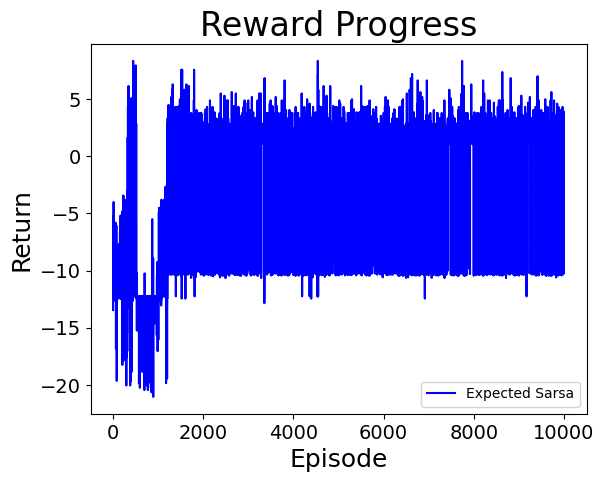

In [9]:
experiments = []

env = Maze(agentXY, goalXY, walls=wall_shape, pits=pits, energy_capacity=50, energy_factor=0.01)
RL = rlalgorithm(actions=list(range(env.n_actions)))
data = {}

env.after(10, update(env, RL, data, episodes))
env.mainloop()
experiments.append((env, RL, data))

for env, RL, data in experiments:
    print(f"""
            [{RL.display_name}]: Max Reward = {np.max(data['global_reward'])}, MedLast100 = {np.median(data['global_reward'][-100:])}, VarLast100 = {np.var(data['global_reward'][-100:])}
          """)
    
if do_plot_rewards:
    plot_rewards(experiments)

The convergence of the algorithm is observed around 1000 episodes for first time. On further increasing the number of episodes to 20000, the agent gives same number of remaining energy without much deviation.

![Episode vs Reward - 2000 Episodes](./output/modified/Reward.png)

## Saving the model

In [10]:
RL.save('./models/model.pkl')

In [12]:
# Reload and run the saved environment
env = Maze(agentXY, goalXY, walls=wall_shape, pits=pits, energy_capacity=50, energy_factor=0.01)
RL = rlalgorithm(actions=list(range(env.n_actions)))
RL.load('./models/model.pkl')
env.run_without_learning(RL, episodes=10, sim_speed=0.001)

Using Expected Sarsa ...
